# Natural Language Processing (NLP) - Spooky Author Identification

**Import (Package) Statments**

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
color = sns.color_palette()


from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string

%config InlineBackend.figure_format = 'retina'



eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pogupt\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Reference Links -
<br>1. https://www.analyticsvidhya.com/blog/2018/05/starters-guide-jupyter-notebook/
<br>2. https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
<br>3. https://www.analyticsvidhya.com/blog/2017/01/ultimate-guide-to-understand-implement-natural-language-processing-codes-in-python/

### Dataset

**https://www.kaggle.com/c/spooky-author-identification**

**Objective of the competition:**

The competition dataset contains text from works of fiction written by spooky authors of the public domain: 
 1. Edgar Allan Poe (EAP)
 2. HP Lovecraft (HPL)
 3. Mary Wollstonecraft Shelley (MWS)
 
The objective  is to accurately identify the author of the sentences in the test set.

**Objective of the notebook:**

In this notebook, let us try to create different features that will help us in identifying the spooky authors. 

As a first step, we will do some basic data visualization and cleaning before we delve deep into the feature engineering part.

**Loading and inspecting data**

Reading the data

In [2]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("spookytrain.csv")
test_df = pd.read_csv("spookytest.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


Displaying the head of the data

In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


Shape of the data

In [4]:
train_df.shape

(19579, 3)

**Bar chart of class proportion**
<br>We can check the number of occurrence of each of the author to see if the classes are balanced. 

C:\Users\pogupt\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


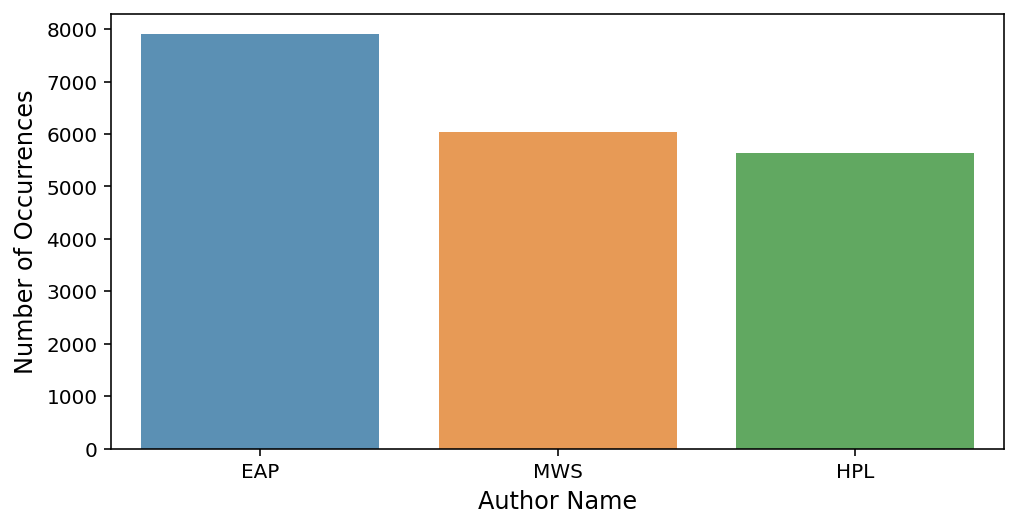

In [5]:
import seaborn as sns
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [6]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul


**Feature Engineering:**

Now let us come try to do some feature engineering. This consists of two main parts.

 1. Meta features - features that are extracted from the text like number of words, number of stop words, number of punctuations etc
 2. Text based features - features directly based on the text / words like frequency, svd, word2vec etc.

**Meta Features:**

We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:
1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords 
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words


In [7]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Let us now plot some of our new variables to see of they will be helpful in predictions.

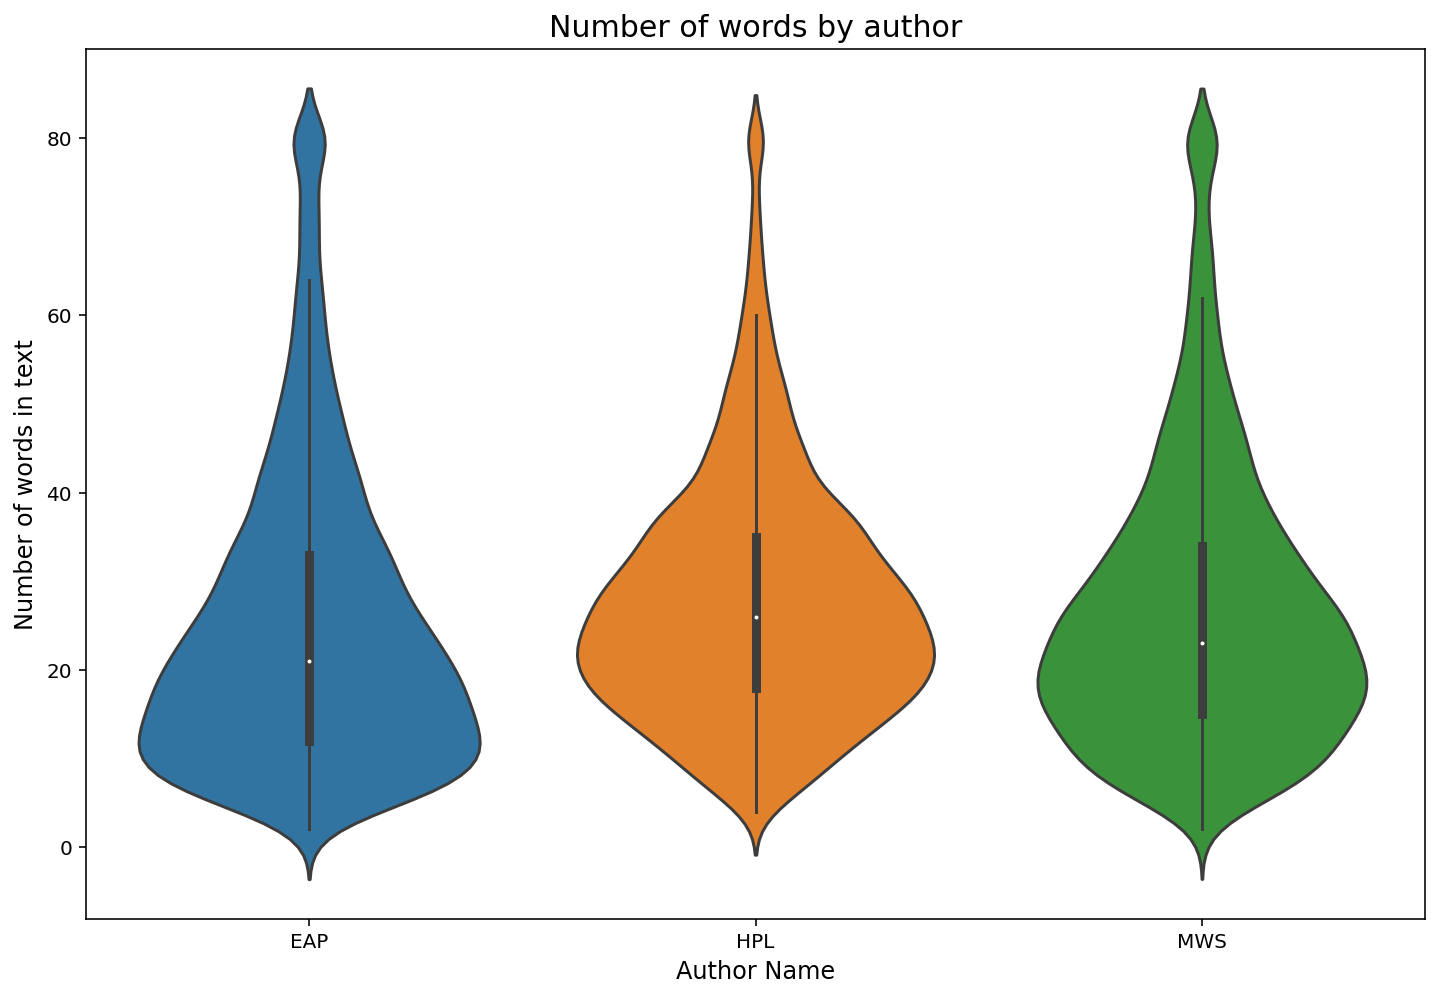

In [8]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

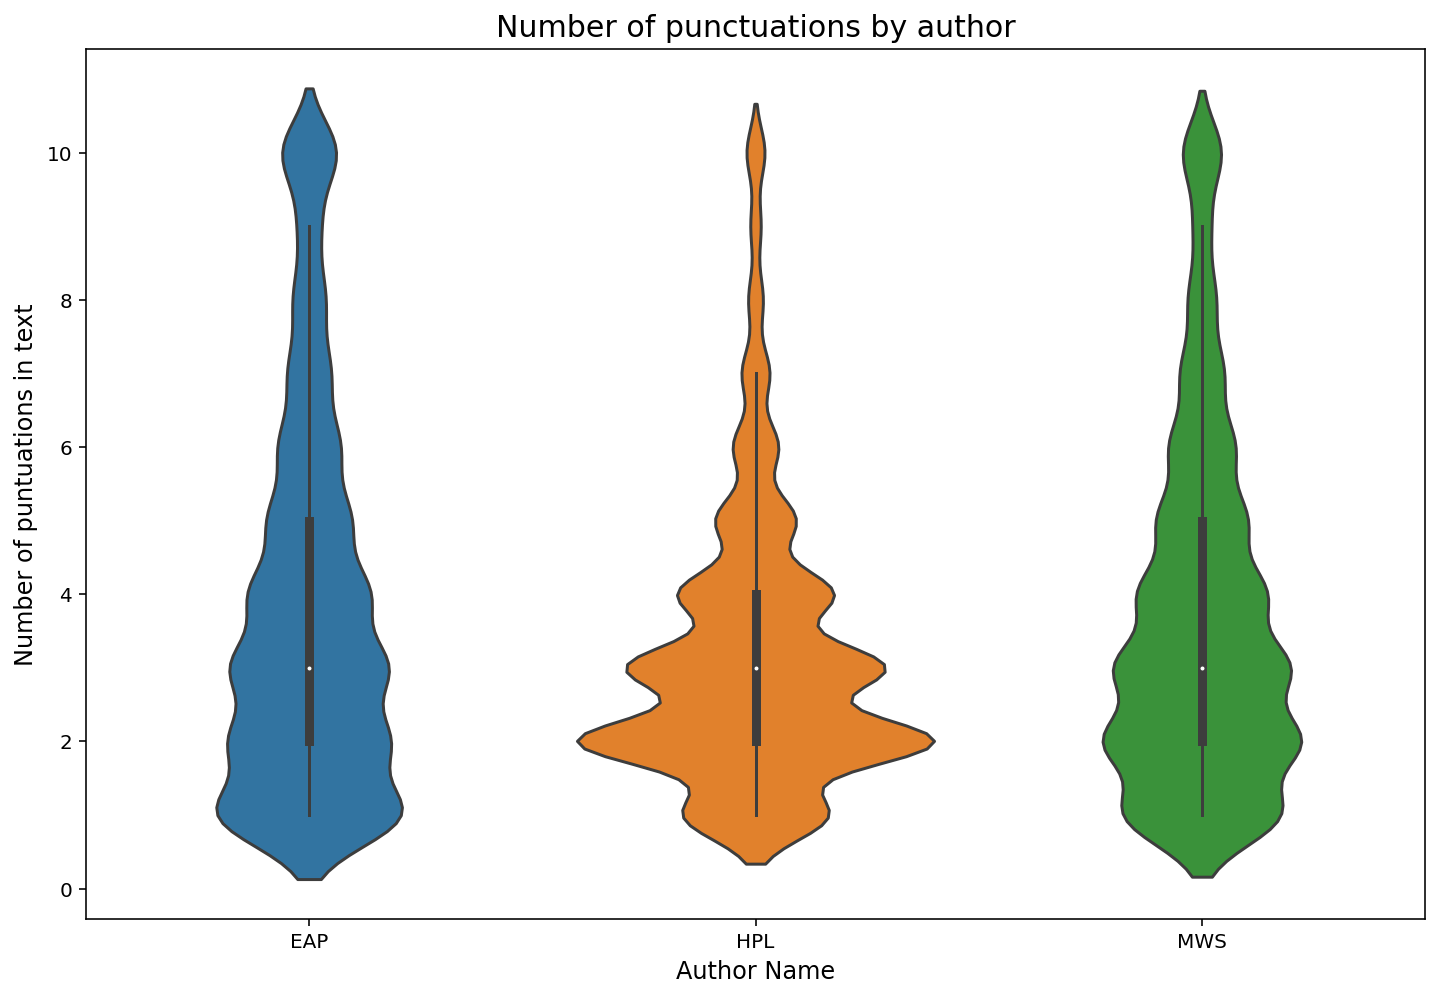

In [9]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [10]:
test_df.head()

,id,text,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id02310,"Still, as I urged our leaving Ireland with suc...",19,19,110,9,3,1,3,4.842105
1,id24541,"If a fire wanted fanning, it could readily be ...",62,49,330,33,7,1,3,4.338710
2,id00134,And when they had broken down the frail door t...,33,30,189,15,3,0,1,4.757576
3,id27757,While I was thinking how I should possibly man...,41,34,223,19,5,2,3,4.463415
4,id04081,I am not sure to what limit his knowledge may ...,11,11,53,6,1,1,1,3.909091


In [11]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [12]:
train_X.head()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,41,35,231,19,7,2,3,4.658537
1,14,14,71,8,1,0,1,4.142857
2,36,32,200,16,5,0,1,4.583333
3,34,32,206,13,4,0,4,5.088235
4,27,25,174,11,4,0,2,5.481481


In [14]:
test_X.head()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,19,19,110,9,3,1,3,4.842105
1,62,49,330,33,7,1,3,4.338710
2,33,30,189,15,3,0,1,4.757576
3,41,34,223,19,5,2,3,4.463415
4,11,11,53,6,1,1,1,3.909091


In [13]:
# instantiate a logistic regression model, and fit with X and y
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(train_X, train_y)

C:\Users\pogupt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# check the accuracy on the training set
model.score(train_X, train_y)

0.49404974717809896

## **NLP Based Feature Engineering**

In [16]:
data=train_df.copy()

## **1. Removing punctions**

**Funtion to remove punctuation**

In [17]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

**Apply the function to each examples**

In [18]:
data['text'] = data['text'].apply(remove_punctuation)
data.head(10)

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,This process however afforded me no means of a...,EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,In his left hand was a gold snuff box from whi...,EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,Finding nothing else not even gold the Superin...,HPL,27,25,174,11,4,0,2,5.481481
5,id22965,A youth passed in solitude my best years spent...,MWS,83,66,468,43,6,5,5,4.650602
6,id09674,The astronomer perhaps at this point took refu...,EAP,21,21,128,9,5,0,1,5.142857
7,id13515,The surcingle hung in ribands from my body,EAP,8,8,43,4,1,0,1,4.500000
8,id19322,I knew that you could not say to yourself ster...,EAP,88,62,488,45,10,4,7,4.556818
9,id00912,I confess that neither the structure of langua...,MWS,23,18,144,11,3,1,1,5.304348


## **2. Removing stopwords**

**Extract the stop words**

In [19]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [20]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


**Function to remove stopwords**

In [21]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

**Apply the function to each examples**

In [22]:
data['text'] = data['text'].apply(stopwords)
data.head(10)

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,process however afforded means ascertaining di...,EAP,41,35,231,19,7,2,3,4.658537
1,id17569,never occurred fumbling might mere mistake,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,left hand gold snuff box capered hill cutting ...,EAP,36,32,200,16,5,0,1,4.583333
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,finding nothing else even gold superintendent ...,HPL,27,25,174,11,4,0,2,5.481481
5,id22965,youth passed solitude best years spent gentle ...,MWS,83,66,468,43,6,5,5,4.650602
6,id09674,astronomer perhaps point took refuge suggestio...,EAP,21,21,128,9,5,0,1,5.142857
7,id13515,surcingle hung ribands body,EAP,8,8,43,4,1,0,1,4.500000
8,id19322,knew could say stereotomy without brought thin...,EAP,88,62,488,45,10,4,7,4.556818
9,id00912,confess neither structure languages code gover...,MWS,23,18,144,11,3,1,1,5.304348


## **Top words before stemming**

**Collect vocabulary count**

We will not use word counts as feature for NLP since tf-idf is a better metric

In [23]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(data['text'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  

Store the vocab and counts in a pandas dataframe

In [24]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

**Bar plot of top words before stemming**

<AxesSubplot:>

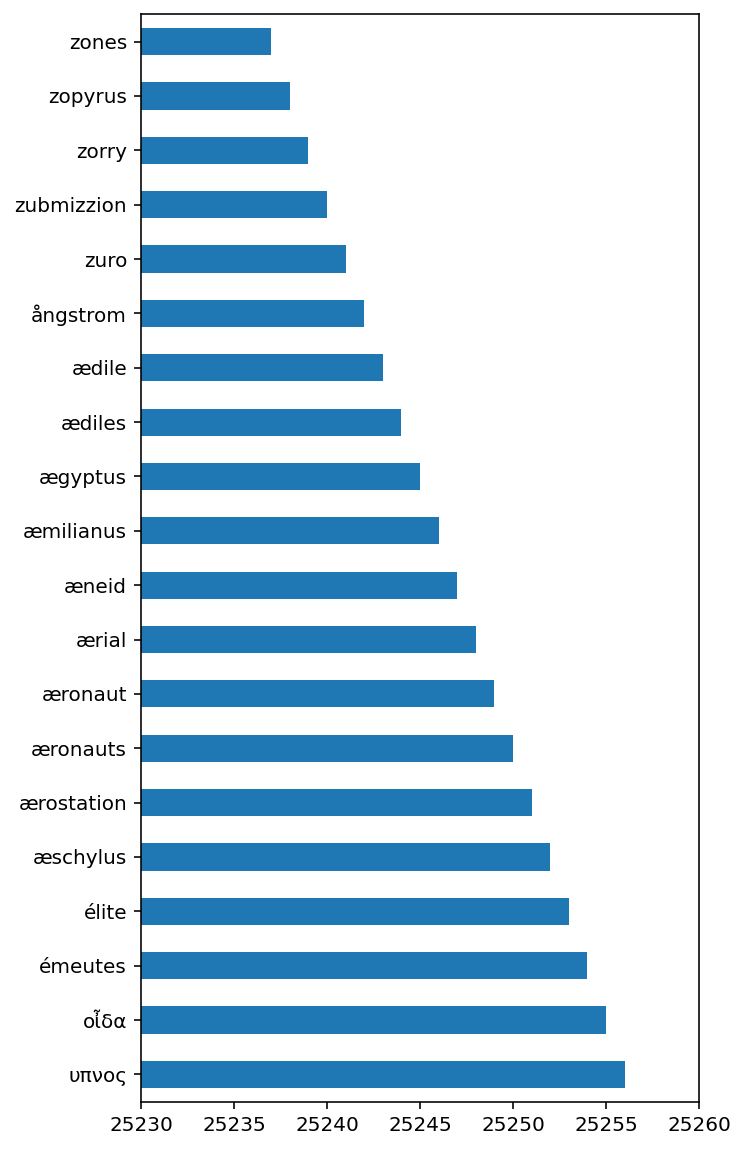

In [25]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (25230, 25260))

##  **3. Stemming operations**

Stemming operation bundles together words of same root. E.g. stem operation bundles "response" and "respond" into a common "respon" 

**A funtion to carry out stemming operation**

In [26]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

**Apply the function to each examples**

In [27]:
data['text'] = data['text'].apply(stemming)
data.head(10)

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,process howev afford mean ascertain dimens dun...,EAP,41,35,231,19,7,2,3,4.658537
1,id17569,never occur fumbl might mere mistak,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,left hand gold snuff box caper hill cut manner...,EAP,36,32,200,16,5,0,1,4.583333
3,id27763,love spring look windsor terrac sixteen fertil...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,find noth els even gold superintend abandon at...,HPL,27,25,174,11,4,0,2,5.481481
5,id22965,youth pass solitud best year spent gentl femin...,MWS,83,66,468,43,6,5,5,4.650602
6,id09674,astronom perhap point took refug suggest non l...,EAP,21,21,128,9,5,0,1,5.142857
7,id13515,surcingl hung riband bodi,EAP,8,8,43,4,1,0,1,4.500000
8,id19322,knew could say stereotomi without brought thin...,EAP,88,62,488,45,10,4,7,4.556818
9,id00912,confess neither structur languag code govern p...,MWS,23,18,144,11,3,1,1,5.304348


## **Top words after stemming operation**

**Collect vocabulary count**

In [30]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer()
# fit the vectorizer using the text data
tfid_vectorizer.fit(data['text'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()  

**Bar plot of top words after stemming**

<AxesSubplot:>

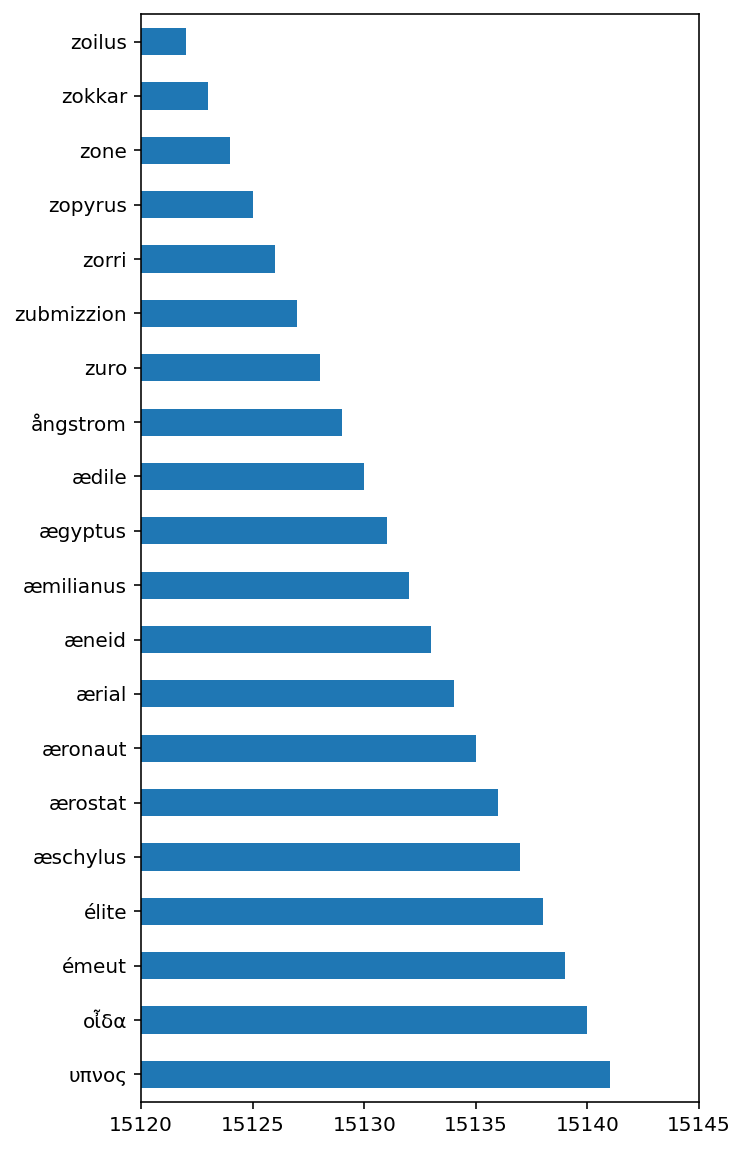

In [31]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (15120, 15145))

## **Histogram of text length of each writer**

A function to return the length of text

In [32]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

Apply the function to each example

In [33]:
data['length'] = data['text'].apply(length)
data.head(10)

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,length
0,id26305,process howev afford mean ascertain dimens dun...,EAP,41,35,231,19,7,2,3,4.658537,136
1,id17569,never occur fumbl might mere mistak,HPL,14,14,71,8,1,0,1,4.142857,35
2,id11008,left hand gold snuff box caper hill cut manner...,EAP,36,32,200,16,5,0,1,4.583333,113
3,id27763,love spring look windsor terrac sixteen fertil...,MWS,34,32,206,13,4,0,4,5.088235,137
4,id12958,find noth els even gold superintend abandon at...,HPL,27,25,174,11,4,0,2,5.481481,102
5,id22965,youth pass solitud best year spent gentl femin...,MWS,83,66,468,43,6,5,5,4.650602,265
6,id09674,astronom perhap point took refug suggest non l...,EAP,21,21,128,9,5,0,1,5.142857,75
7,id13515,surcingl hung riband bodi,EAP,8,8,43,4,1,0,1,4.500000,25
8,id19322,knew could say stereotomi without brought thin...,EAP,88,62,488,45,10,4,7,4.556818,267
9,id00912,confess neither structur languag code govern p...,MWS,23,18,144,11,3,1,1,5.304348,80


**Extracting data of each class**

In [34]:
EAP_data = data[data['author'] == 'EAP']
HPL_data = data[data['author'] == 'HPL']
MWS_data = data[data['author'] == 'MWS']

**Histogram of text lenght of  each writer**

As we can see the distributions coincides so it better to leave out text length as a feature for predictive modelling

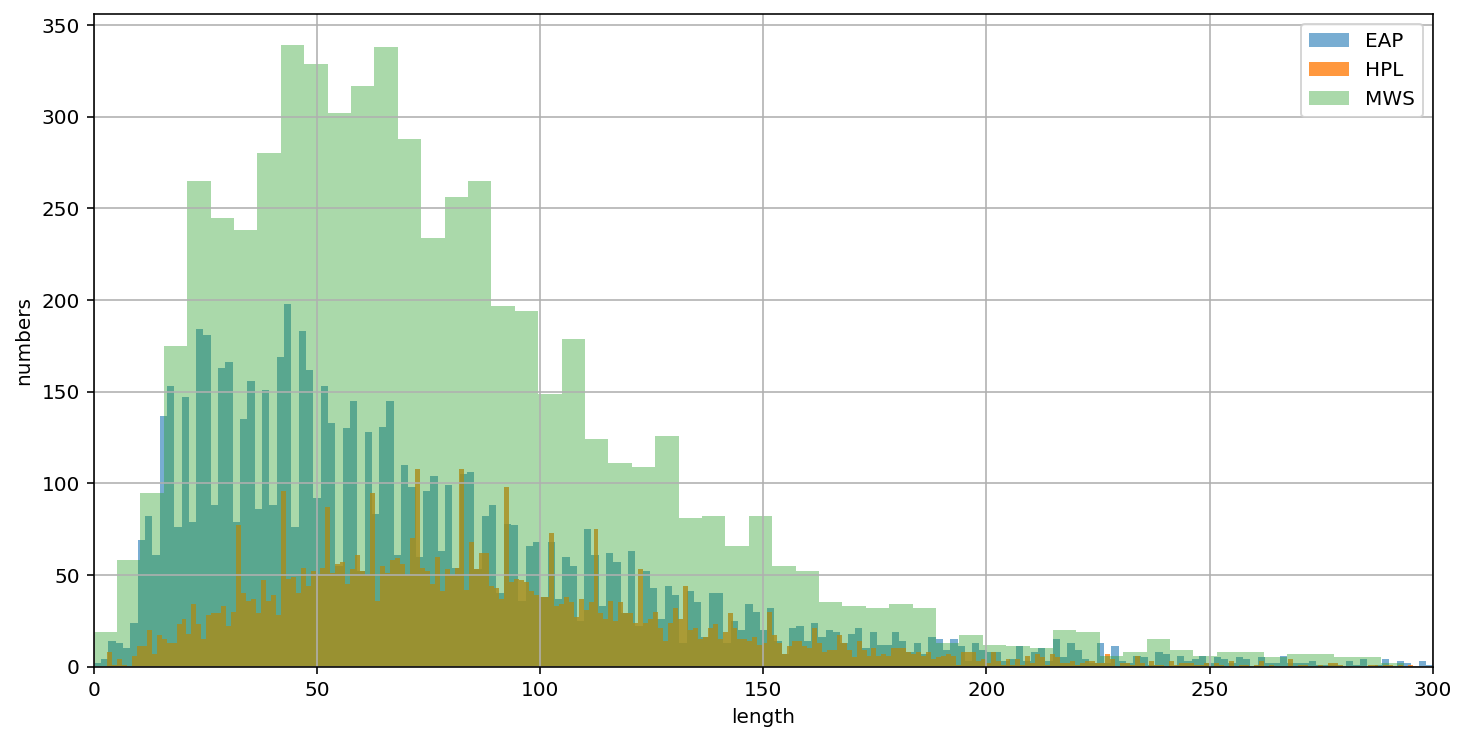

In [35]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500
plt.hist(EAP_data['length'], alpha = 0.6, bins=bins, label='EAP')
plt.hist(HPL_data['length'], alpha = 0.8, bins=bins, label='HPL')
plt.hist(MWS_data['length'], alpha = 0.4, bins=bins, label='MWS')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

# **Top words of each writer and their count**

## **Edgar Allan Poe**

<AxesSubplot:>

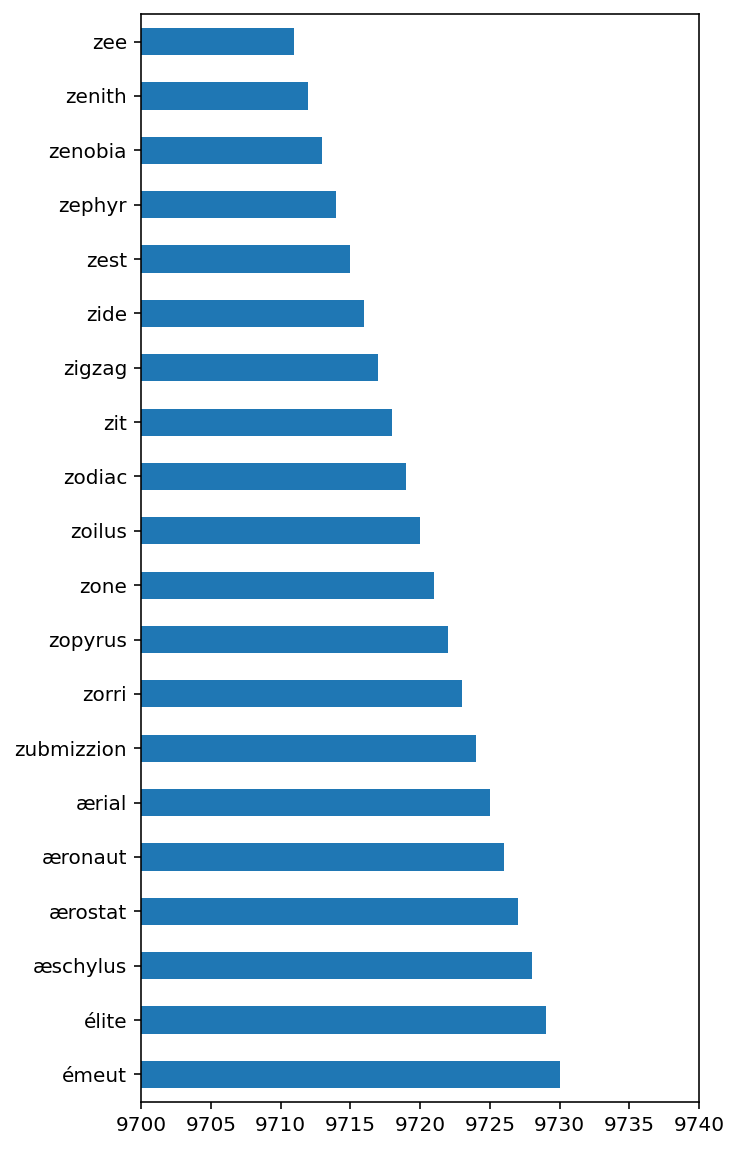

In [37]:
# create the object of tfid vectorizer
EAP_tfid_vectorizer = TfidfVectorizer()
# fit the vectorizer using the text data
EAP_tfid_vectorizer.fit(EAP_data['text'])
# collect the vocabulary items used in the vectorizer
EAP_dictionary = EAP_tfid_vectorizer.vocabulary_.items()

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in EAP_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
EAP_vocab = pd.Series(count, index=vocab)
# sort the dataframe
EAP_vocab = EAP_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = EAP_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (9700, 9740))

## **Mary Shelley**

<AxesSubplot:>

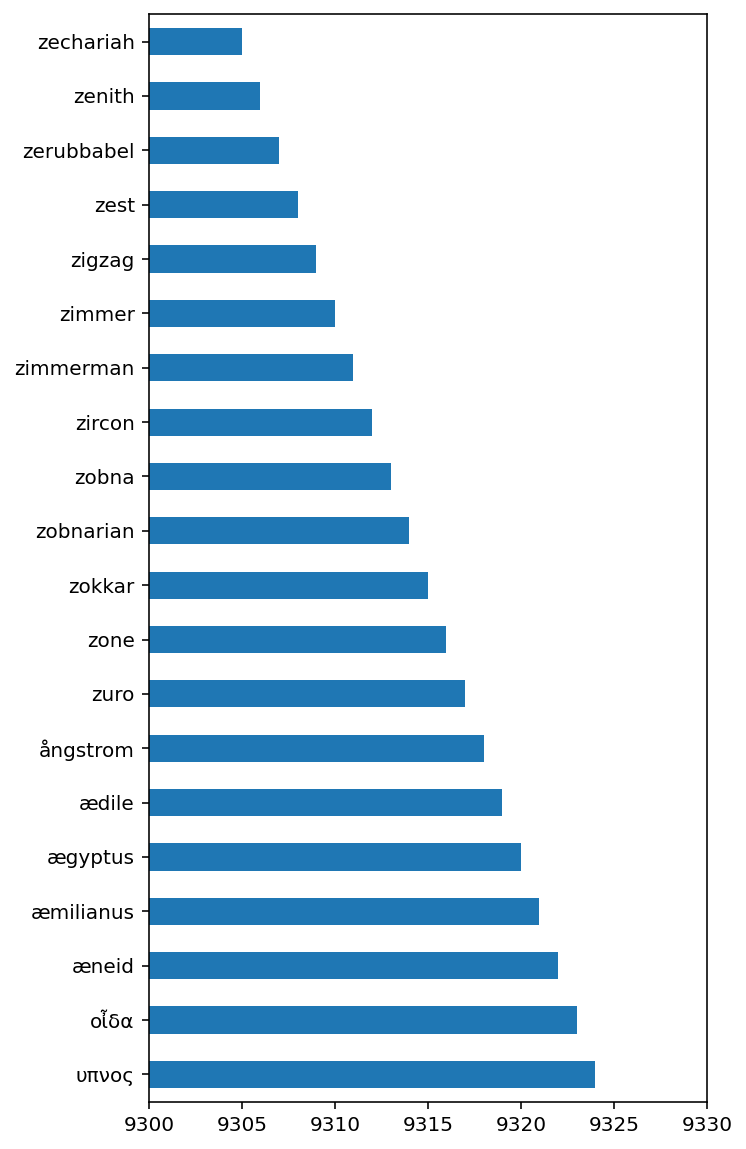

In [38]:
# create the object of tfid vectorizer
HPL_tfid_vectorizer = TfidfVectorizer()
# fit the vectorizer using the text data
HPL_tfid_vectorizer.fit(HPL_data['text'])
# collect the vocabulary items used in the vectorizer
HPL_dictionary = HPL_tfid_vectorizer.vocabulary_.items()
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in HPL_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index    
HPL_vocab = pd.Series(count, index=vocab)
# sort the dataframe
HPL_vocab = HPL_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = HPL_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (9300, 9330))

## **HP Lovecraft**

<AxesSubplot:>

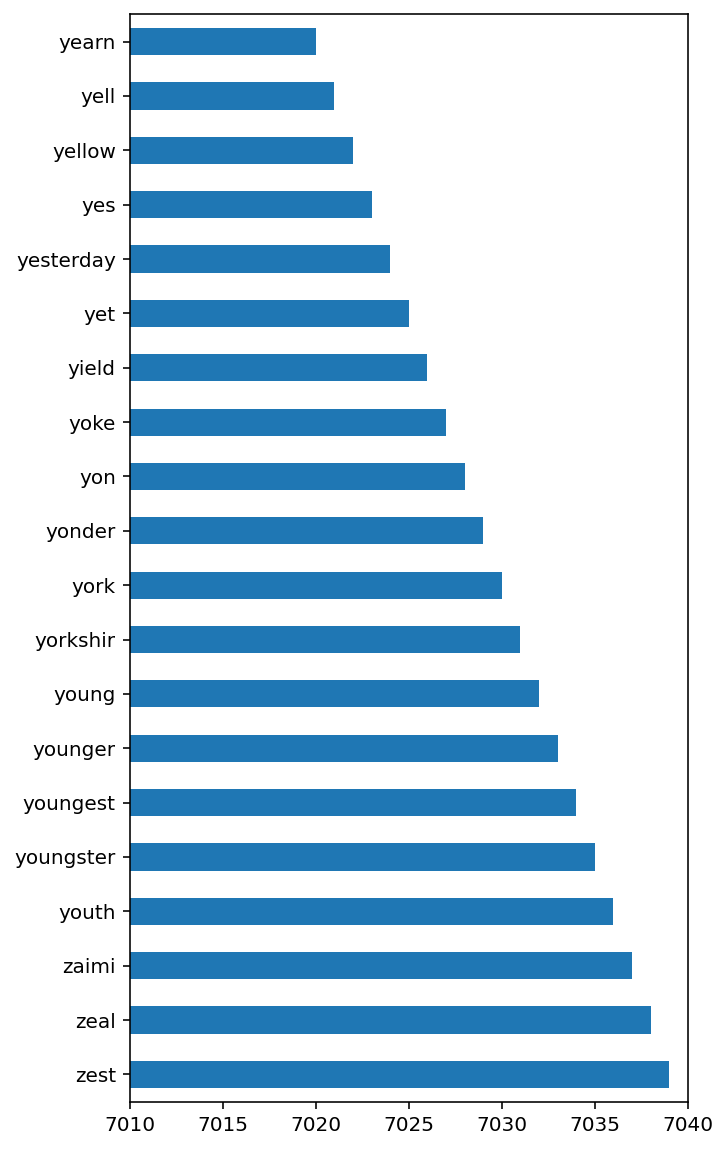

In [39]:
# create the object of tfid vectorizer
MWS_tfid_vectorizer = TfidfVectorizer()
# fit the vectorizer using the text data
MWS_tfid_vectorizer.fit(MWS_data['text'])
# collect the vocabulary items used in the vectorizer
MWS_dictionary = MWS_tfid_vectorizer.vocabulary_.items()
# lists to store the vocab and counts

vocab = []
count = []
# iterate through each vocab and count append the value to designated list
for key, value in MWS_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe and vocab as index    
MWS_vocab = pd.Series(count, index=vocab)
# sort the dataframe
MWS_vocab = MWS_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = MWS_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (7010, 7040))

**As we can see the top words of each writer are cleary distinct and are in huge numbers. Word Count or TF-IDF of the can provide a good feature**

# **TF-IDF Extraction**

tf-idf weight is product of two terms: the first term is the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [40]:
# extract the tfid representation matrix of the text data
tfid_matrix = tfid_vectorizer.transform(data['text'])
# collect the tfid matrix in numpy array
array = tfid_matrix.todense()

In [42]:
# store the tf-idf array into pandas dataframe
df = pd.DataFrame(array)
df

,0,1,2,3,4,5,6,7,8,9,...,15132,15133,15134,15135,15136,15137,15138,15139,15140,15141
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.266318,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19574,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19575,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19576,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19577,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Training Model**

We are going to train Naive Bayes Classifier. Naive Bayes Classifier is a good choice given we have a medium sized dataset, NB classifier scales well and also NB classifier has been historically used in NLP tasks. We will train Multinomial and Bernoulli NB classifier, since they almost always outperfrom Gaussian NB classifier in NLP tasks

Adding the output to the dataframe

In [43]:
df['output'] = data['author']
df['id'] = data['id']
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15134,15135,15136,15137,15138,15139,15140,15141,output,id
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id26305
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HPL,id17569
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id11008
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MWS,id27763
4,0.0,0.0,0.0,0.0,0.266318,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HPL,id12958
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MWS,id22965
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id09674
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id13515
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id19322
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MWS,id00912


Features and output of the models

In [ ]:
features = df.columns.tolist()
output = 'output'
# removing the output and the id from features
features.remove(output)
features.remove('id')